In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from IPython.display import HTML
from collections import deque
import importlib


%load_ext autoreload
%autoreload 2

In [2]:
import simulation
import controller
from simulation import *
from dqn_main_bus import DQNMainBus
from main_bus import MainBus

Using TensorFlow backend.


### Initialization

In [5]:
whole_day = 1440

# Parameters
MainBus._WAITING_TIME_VOTING_SMOOTHING = 0

replay_length = 100000
iterations = 144 # num of ticks before training
epochs = 2000 # num of times network is unfrozen, trained
batch_size = 100 # num of samples from replay memory to train on
animate = False
add_arrivals_noise = False

# Model
loggers = []#StateLogger(bus_id=24, save_every=1)]
simulation = Simulation(DQNMainBus, loggers=loggers)
replay_memory = deque(maxlen = replay_length)
training_results = []
training_loss = []
delivered_passeners = []
total_expenses = []
total_waiting_time = []
total_messages_sent = []

save_every = 10

exploration_parameter = 0.1
decay_rate = 1e-8

Initializing Prob Dist


### Training

In [6]:
# Main training loop

for epoch in range(epochs):
    print('Epoch #%d' % (epoch+1))
    day_time = 0
    simulation.reset(add_arrivals_noise=add_arrivals_noise) # resets everything
    
    while day_time < whole_day:
        training_results.append(simulation.execute(iterations=iterations)) # simulate and collect logs
        
        replay_memory.extend(simulation.controller.replay_memory) # store data into replay memory

        if len(replay_memory)  > batch_size:
            # Get random samples
            training_idx = np.random.choice(len(replay_memory), size = batch_size)
            training_samples = [replay_memory[i] for i in training_idx]

            # Train DQN
            simulation.controller.destination_model.train(training_samples)
            
            # Decrease exploration parameter
            DQNMainBus._EXPLORATION_PARAMETER = exploration_parameter
            exploration_parameter -= 1e-8
        
        day_time += iterations
        
    training_loss.append(simulation.controller.get_total_cost()) # collect loss
    delivered_passeners.append(simulation.controller.num_passengers_delivered)
    
    waiting_time = simulation.controller.total_waiting_time
    cost = simulation.controller.get_execution_cost()
    messages_sent = simulation.controller.get_messages_sent()
    
    total_waiting_time.append(waiting_time)
    total_expenses.append(cost)
    total_messages_sent.append(messages_sent)
    
    print('\r\tdelivered:{}'.format(simulation.controller.num_passengers_delivered))
    print('# buses:{}'.format(len(simulation.controller.buses)))
    print('waiting_time:{}'.format(waiting_time))
    print('cost:{}'.format(cost))
    print('messages:{}'.format(messages_sent))
    
    
    if epoch % save_every == 0:
        simulation.controller.save_destination_model('decision_model_final')
        print('### CHECKPOINT ###')

Epoch #1
 144 / 144 

/home/marco/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2096: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


	delivered:36639
# buses:30
waiting_time:7654518
cost:407741.5
messages:11878
### CHECKPOINT ###
Epoch #2
	delivered:37395
# buses:30
waiting_time:7347018
cost:407646.0
messages:12219
Epoch #3
	delivered:37997
# buses:30
waiting_time:6970080
cost:407457.5
messages:12120
Epoch #4
	delivered:37339
# buses:30
waiting_time:7229460
cost:407673.5
messages:12103
Epoch #5
	delivered:36677
# buses:30
waiting_time:8090001
cost:407765.5
messages:11813
Epoch #6
	delivered:38279
# buses:30
waiting_time:6759799
cost:407430.0
messages:12099
Epoch #7
	delivered:38523
# buses:30
waiting_time:6591198
cost:407531.5
messages:12047
Epoch #8
	delivered:37443
# buses:30
waiting_time:7970736
cost:407646.5
messages:12152
Epoch #9
	delivered:37249
# buses:30
waiting_time:7677053
cost:407638.5
messages:12059
Epoch #10
	delivered:37241
# buses:30
waiting_time:8059017
cost:407519.5
messages:12013
Epoch #11
	delivered:38078
# buses:30
waiting_time:6830535
cost:407623.5
messages:11976
### CHECKPOINT ###
Epoch #12
	d

KeyboardInterrupt: 

In [5]:
len(replay_memory)

100000

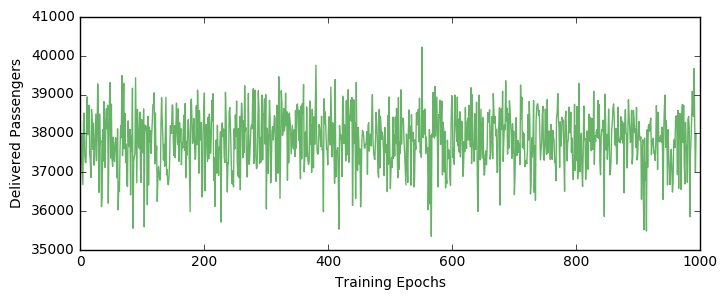

In [19]:
# plt.plot(training_loss, 'r-')
# plt.title('Loss')
# plt.show()
plt.figure(figsize=(8,3))
plt.plot(delivered_passeners, 'g-', alpha=0.6)

plt.ylabel('Delivered Passengers')
plt.xlabel('Training Epochs')
plt.show()

# plt.plot(total_waiting_time, 'y-')
# plt.show()

In [7]:
simulation.reset()
simulation.execute(iterations=500, animate=True, interval=500)

{}

In [8]:
HTML(simulation.anim.to_html5_video())

499

In [8]:
print('\r\tdelivered:{}'.format(simulation.controller.num_passengers_delivered))

	delivered:119


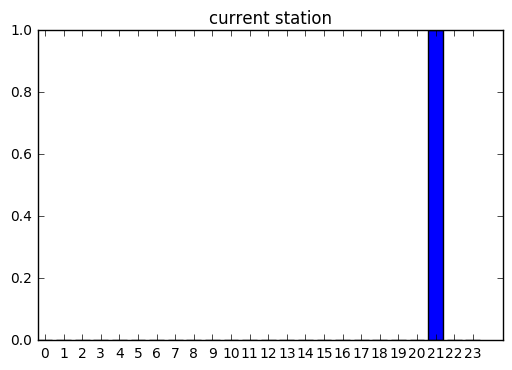

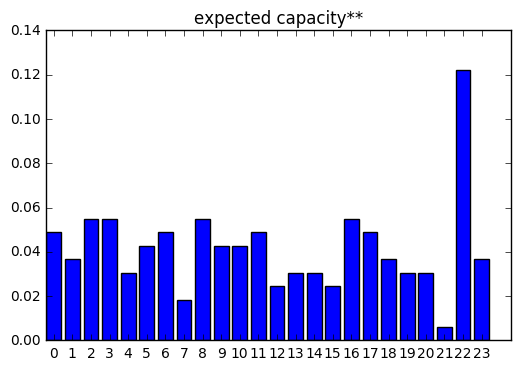

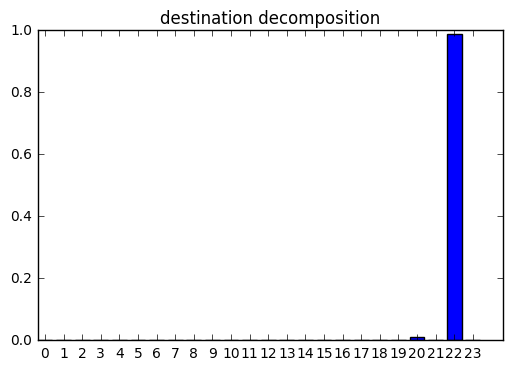

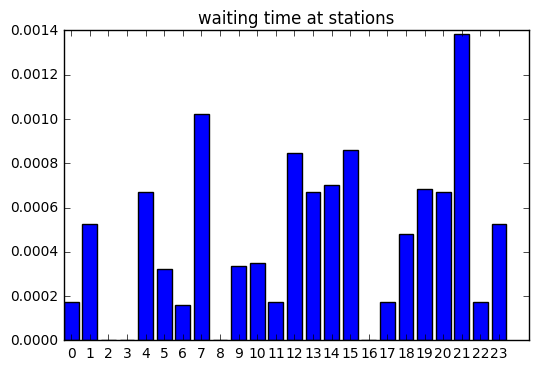

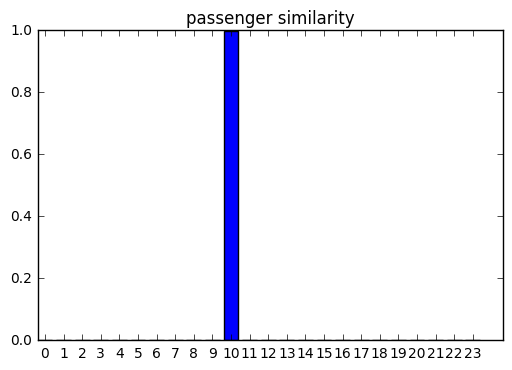

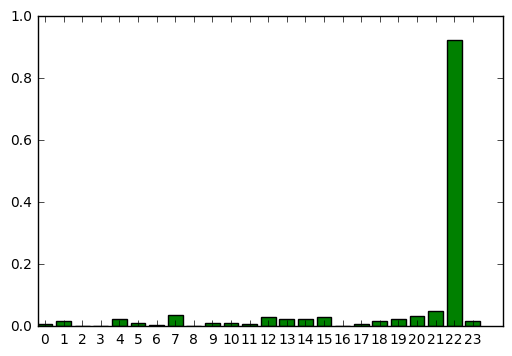

In [10]:
choice = 2


state = simulation.controller.logged_data['Bus 24 State Logger'][choice].T
s = np.zeros((24,1))
titles = ['current station','expected capacity**','destination decomposition','waiting time at stations','passenger similarity']
for i in range(5):
    if i>0:
        s += state[i*24:(i+1)*24] * (-1 if i==1 else (0 if i==4 else 1))
    plt.title(titles[i])
    plt.bar(range(24), state[i*24:(i+1)*24])
    plt.xticks(np.array(range(24))+0.4,range(24))
    plt.show()
        
plt.bar(range(24), s-s.min(), color='g')
plt.xticks(np.array(range(24))+0.4,range(24))
plt.show()
    
